In [1]:
from eda_import import *

In [2]:
from utils.parse_gtf_utils import extract_info
from utils.calc_clv_sc import get_strand, get_num_sc

import utils.plot_bars as PB
import utils.plot_arcs as PA
import utils.plot_utrs as PU
import utils.plot_clvs as PC

In [3]:
%%time
df_clv = pd.read_csv('./results_data/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv.gz', 
                     compression='gzip',
                     usecols=['analysis_id', 'disease', 'sstype', 'mkid', 'gene_name',
                              'participant_id', 'mclv', 'strand'])

CPU times: user 16.6 s, sys: 220 ms, total: 16.8 s
Wall time: 16.9 s


In [4]:
%time df_expr = pd.read_csv('./results_data/RPKMS.csv.gz', compression='gzip')

CPU times: user 528 ms, sys: 1.69 ms, total: 529 ms
Wall time: 532 ms


In [5]:
df_cytoband = pd.read_csv('./reference_data/GRCh37.p13.mart_export.cytoband_info.txt.gz', sep='\t')
df_cytoband.columns = [_.lower().replace(' ', '_') for _ in df_cytoband.columns.values.tolist()]
# df_cytoband.rename(columns={'hgnc_symbol': 'gene_name'}, inplace=True)

In [6]:
df_cytoband.head(1)

,gene_stable_id,transcript_stable_id,chromosome/scaffold_name,gene_start_(bp),gene_end_(bp),strand,karyotype_band,gene_name,gene_type,transcript_type,hgnc_symbol,ucsc_stable_id
0,ENSG00000261657,ENST00000566782,HG991_PATCH,66119285,66465398,1,p14.1,SLC25A26,protein_coding,protein_coding,SLC25A26,NaN


In [7]:
TARGET_GENES = np.sort(df_clv.gene_name.unique()).tolist()

#### some preliminary analysis on the cytobands

In [8]:
df_cytoband.groupby('gene_name').apply(
    lambda grp: grp.karyotype_band.unique().shape[0]).unique()

array([ 17,   9,   1,   2,   3,   5,  24,   4,   6,   8,  20,  23,  19,
        12,  13,   7,  26,  36,  61,  16, 192, 163])

In [9]:
bands_per_gene = df_cytoband.groupby('gene_name').apply(
    lambda grp: grp.karyotype_band.unique())

In [10]:
df_bands = bands_per_gene.to_frame(name='bands')
df_bands['num'] = df_bands['bands'].apply(len)

In [11]:
df_bands = df_bands.reset_index().rename(columns={'index': 'gene_name'})

In [12]:
df_bands.query('gene_name in {0}'.format(
    ['FGF2', 'CCNE1', 'RNF43', 'CDKN2A', 'EZH2', 'PTCH1']))

,gene_name,bands,num
9582,CCNE1,[q12],1
9879,CDKN2A,[p21.3],1
15460,EZH2,[q36.1],1
16249,FGF2,[q27],1
29494,PTCH1,[q22.32],1
32250,RNF43,[q22],1


In [13]:
df_bands.num.value_counts().to_frame().T

,1,2,3,5,4,6,7,8,9,26,163,36,61,12,13,16,17,19,20,23,24,192
num,56285,241,55,13,11,8,5,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1


In [14]:
df_bands.query('num > 190')

,gene_name,bands,num
55574,Y_RNA,"[q11.2, q21.2, q12.1, q23.3, q21.3, p13.3, q21.1, q15.2, p13.2, p12.1, p11.23, q15.3, p11.21, p11.2, q22.31, q21.31, q11.21, q11.22, q22.32, q13, p22.1, p35.2, nan, q11.23, q21.12, q22.13, q21.13, p21.32, q12.3, q12, q21.33, q13.11, q13.12, q22.33, q22.2, q13.2, q21.32, q13.13, q13.31, p14, q24, q13.33, q23, p13, q22.1, q31.3, q26.1, q32.3, q32, p12, p14.2, q22.3, p22.3, p11.22, q25, p15.5, p32.3, q14.1, p21.1, p24.3, p15, q44, p12.3, q22, p24.2, q32.11, q32.1, q33.2, q25.3, q23.2, q33.3, q26.2, q24.3, q26.31, q13.1, p15.4, p32.1, q24.2, q34.11, p31.3, p36.13, p12.2, q26.3, q23.1, q14.2, q24.1, p13.1, p21, p22.2, q31.1, p22, p36.12, p36.11, p25.1, q27, q34, q35.1, q32.12, q25.1, p35.3, ...]",192


In [15]:
df_bands.query('num > 2').sample()

,gene_name,bands,num
18302,HLA-DRB8,"[p21.32, p21.33, p22.1]",3


#### Now focus on the target genes

In [16]:
df_cyb = df_cytoband.query('gene_name in {0}'.format(TARGET_GENES)).copy()
assert df_cyb.gene_name.unique().shape[0] == 114
assert df_cyb.groupby('gene_name').apply(
    lambda grp: grp.karyotype_band.unique().shape[0]).unique()[0] == 1

In [17]:
CB_DD = dict(df_cyb[['gene_name', 'karyotype_band']].drop_duplicates().values)

In [18]:
clv_sc_df = pd.read_csv(
    './reference_data/annotated-clv-sc-mapping.csv.gz', compression='gzip',
    usecols=['seqname', 'gene_name', 'strand', 'source', 'aclv', 'sc']
)
clv_sc_df.drop_duplicates(inplace=True)
clv_sc_df.reset_index(drop=True, inplace=True)

In [19]:
assert clv_sc_df.shape[0] == 467

In [20]:
clv_sc_df.head(2)

,gene_name,seqname,source,sc,strand,aclv
0,ABL1,9,protein_coding,133761070,+,133763062
1,AKT1,14,protein_coding,105236678,-,105235686


In [21]:
def calc_offset(grp_by_gene):
    grp = grp_by_gene.copy()
#     grp = grp_by_gene.query('source == "protein_coding"')
    if grp.shape[0] == 0:
        grp = grp_by_gene
    assert grp.strand.unique().shape[0] == 1
    strand = grp.strand.unique()[0]
    if strand == '+':
        return grp.sc.values.min()
    elif strand == '-':
        return grp.sc.values.max()
    else:
        raise
        
# offset to the first protein_coding stop codon
offsets = clv_sc_df[['gene_name', 'sc', 'aclv', 'strand', 'source']]\
    .groupby('gene_name')\
    .apply(calc_offset)\
    .to_frame(name='offset')\
    .reset_index()

clv_sc_df = clv_sc_df.merge(offsets, on='gene_name', how='left')

clv_sc_df['sc_t'] = (clv_sc_df.sc - clv_sc_df.offset)
clv_sc_df['aclv_t'] = (clv_sc_df.aclv - clv_sc_df.offset)
clv_sc_df['adiff'] = clv_sc_df.aclv - clv_sc_df.sc
clv_sc_df['alen'] = (clv_sc_df.aclv - clv_sc_df.sc).abs()

In [22]:
clv_sc_df.head(1)

,gene_name,seqname,source,sc,strand,aclv,offset,sc_t,aclv_t,adiff,alen
0,ABL1,9,protein_coding,133761070,+,133763062,133761070,0,1992,1992,1992


In [23]:
clv_sc_df.source.value_counts()

protein_coding             364
nonsense_mediated_decay    103
Name: source, dtype: int64

In [24]:
%time adf = pd.read_csv('./results/aca_pval_with_sc_info.csv')

CPU times: user 54.3 ms, sys: 951 µs, total: 55.2 ms
Wall time: 57 ms


In [25]:
adf.head(2)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca,sc_list,src_list,num_sc
0,BLCA,ABL1,chr9|ABL1|+|133589972,133589972,+,133763062,1,23,18,382,1.0,19,405,0.052632,0.05679,0.004159,False,up,NaN,False,133761070,protein_coding,1
1,BLCA,ABL1,chr9|ABL1|+|133763062,133763062,+,133763062,19,405,0,0,1.0,19,405,1.000000,1.00000,0.000000,False,down,NaN,False,133761070,protein_coding,1


In [26]:
_df = adf.query('has_diff_aca == True').copy()
occur_cutoff = 0.05
sig_mkids = _df[-((_df.N_on_ratio < occur_cutoff) &
                  (_df.T_on_ratio < occur_cutoff) &
                  (_df.diff_is_significant == False))].mkid.unique().tolist()
print(len(sig_mkids))

# sig_mkids = _df[-((_df.N_on_ratio < 0.1) & (_df.T_on_ratio < 0.1))].mkid.unique().tolist()

# only show KLEAT clvs that have undergo significant change in at least one cancer type, but show all annotated ones
# sig_mkids = adf.query('has_diff_aca == True').query('diff_is_significant == True').mkid.unique().tolist()
bdf = adf.query('has_diff_aca == True').query('mkid in {0}'.format(sig_mkids))

# negative ctrl
_df = adf.query('gene_name == "FGF2"')\
    .query('disease == "THCA"')\
    .query('mkid in {0}'.format(sig_mkids))
cdf = pd.concat([bdf, _df])

181


In [27]:
bdf.gene_name.unique().shape

(33,)

In [28]:
bdf[['gene_name', 'disease']].drop_duplicates().shape

(77, 2)

In [29]:
bdf[['gene_name', 'disease']].drop_duplicates().groupby('gene_name').count().max()

disease    8
dtype: int64

In [30]:
bdf.query('gene_name == "FGF2"').head(1)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca,sc_list,src_list,num_sc
1064,BRCA,FGF2,chr4|FGF2|+|123813648,123813648,+,123816619,11,50,59,561,0.04592,70,611,0.157143,0.081833,-0.07531,False,down,NaN,True,123813551,protein_coding,1


In [31]:
for gene in ['FGF2', 'CCNE1', 'CDKN2A', 'EZH2', 'PTCH1']:
    _val = bdf.query('gene_name == "{0}"'.format(gene)).mclv.unique()
    print(gene, '\t', _val.shape[0], np.sort(_val).tolist())

FGF2 	 4 [123813648, 123816621, 123818762, 123819379]
CCNE1 	 3 [30314898, 30315134, 30315215]
CDKN2A 	 6 [21967755, 21967992, 21968200, 21968733, 21969564, 21970697]
EZH2 	 3 [148504477, 148504561, 148515148]
PTCH1 	 7 [98205278, 98205693, 98206430, 98208439, 98242800, 98244110, 98244231]


In [32]:
assert cdf[cdf.num_sc.isnull()].shape[0] == 0

So it's mostly zeros, which is a justification for separating them

**Note**: for those with N2T_ratio_diff < 0.02 (the arrow head length), none is a significant change, so just leave it as it is.

In [33]:
ddf = cdf.merge(clv_sc_df[['aclv', 'offset']].drop_duplicates(), on='aclv')
ddf['mclv_t'] = ddf['mclv'] - ddf['offset']
assert ddf.shape[0] == cdf.shape[0]

In [34]:
arc_df = clv_sc_df.copy()
arw = ddf.copy() # arw: arrow

In [35]:
RECUR_DD = ddf[['disease', 'gene_name']]\
    .drop_duplicates()\
    .groupby('gene_name')\
    .apply(lambda g: g.disease.unique().shape[0])\
    .to_dict()

In [36]:
def calc_recur(gene_name, dise):
    total = RECUR_DD[gene_name] 
    if gene_name == 'FGF2':
        # remove THCA
        return RECUR_DD.get(gene_name) - 1 
    if gene_name == 'RNF43':
        return 1
    if gene_name == 'CDKN2A':
        if dise == 'HNSC':
            return 1
        else:
            return RECUR_DD.get('CDKN2A') - 1
    return RECUR_DD.get(gene_name, -1)

In [37]:
# BS: bootstrap
BS_BLUE = (np.array([2, 117, 216]) / 255).tolist()
BS_GREEN = (np.array([92, 184, 89]) / 255).tolist()
BS_RED  = (np.array([217, 83, 79]) / 255).tolist()
BS_ORANGE = (np.array([240, 173, 78]) / 255).tolist()

def trend2bgcol(grp):
    assert grp.trend.unique().shape[0] == 1
#     dd = {0: 'white', -1: BS_BLUE, 1: BS_RED}
    # color from https://designschool.canva.com/blog/100-color-combinations/
    dd = {0: 'white', -1: '#20948B', 1: '#DE7A22'} # a darker orange
    return dd[grp.trend.values[0]]

trends_df = pd.read_csv('./results/aca_trends.csv')
bg_color_dd = trends_df.groupby(['gene_name', 'disease']).apply(trend2bgcol).to_dict()

In [38]:
trends_df.query('trend != 0').gene_name.unique().shape

(17,)

In [39]:
trends_df.trend.value_counts()

 0    45
-1    16
 1    16
Name: trend, dtype: int64

In [40]:
gd_pairs = [
    ('LUAD', 'FGF2'), ('LUAD', 'CCNE1'), 
    ('KIRC', 'RNF43'), ('UCEC', 'RNF43'),
    ('THCA', 'CDKN2A'), ('HNSC', 'CDKN2A')
]

for (i, j) in gd_pairs:
    print(tuple([j, i]))

('FGF2', 'LUAD')
('CCNE1', 'LUAD')
('RNF43', 'KIRC')
('RNF43', 'UCEC')
('CDKN2A', 'THCA')
('CDKN2A', 'HNSC')


In [41]:
ddf.query('gene_name in ["FGF2", "CCNE1"]')[['gene_name', 'disease']].drop_duplicates().disease.value_counts()

LUAD    2
BRCA    2
LUSC    2
PRAD    1
LIHC    1
HNSC    1
KIRP    1
THCA    1
Name: disease, dtype: int64

In [42]:
ddf.head(2)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca,sc_list,src_list,num_sc,offset,mclv_t
0,BLCA,BRCA1,chr17|BRCA1|-|41196318,41196318,-,41196313,13,401,6,13,0.000059,19,414,0.684211,0.968599,0.284389,True,up,up,True,41197695,protein_coding,1,41262552,-66234
1,KIRC,BRCA1,chr17|BRCA1|-|41196318,41196318,-,41196313,54,472,18,63,0.004720,72,535,0.750000,0.882243,0.132243,True,up,up,True,41197695,protein_coding,1,41262552,-66234


In [43]:
ddf.query('gene_name == "FGF2"').query('mkid == "chr4|FGF2|+|123813648"')[['disease', 'N_on_ratio', 'T_on_ratio', 'diff_is_significant']].sort_values('T_on_ratio').reset_index(drop=False)

,index,disease,N_on_ratio,T_on_ratio,diff_is_significant
0,91,LUAD,0.033333,0.046931,False
1,95,PRAD,0.138889,0.079861,False
2,89,BRCA,0.157143,0.081833,False
3,97,THCA,0.028571,0.130312,False
4,93,LUSC,0.071429,0.208861,False


In [44]:
for (gene, dise) in PA.MAIN_PLOT_GD_PAIRS_SIMPLE + PA.MAIN_PLOT_GD_PAIRS_COMPLEX:
    print(gene, '\t', dise, np.sort(ddf.query('gene_name == "{0}"'.format(gene)).query('disease == "{0}"'.format(dise)).mclv.unique()))

FGF2 	 LUAD [123813648 123816621 123819379]
CCNE1 	 LUAD [30314898 30315134 30315215]
RNF43 	 KIRC [56429878 56431037 56432284 56434325]
RNF43 	 UCEC [56429878 56431037 56432284 56434325]
CDKN2A 	 KIRC [21967755 21967992 21968200 21968733 21969564 21970697]
CDKN2A 	 HNSC [21967755 21967992 21968200 21968733 21969564 21970697]
EZH2 	 LUAD [148504477 148504561 148515148]
PTCH1 	 BRCA [98205278 98205693 98206430 98208439 98242800 98244110 98244231]



## 4 x 1 simple & complex

working on FGF2, LUAD,['F1', 'F2', 'F3']
working on CCNE1, LUAD,['C1', 'C2', 'C3']
working on RNF43, KIRC,['R1', 'R2', 'R3', 'R4']
working on RNF43, UCEC,['R1', 'R2', 'R3', 'R4']


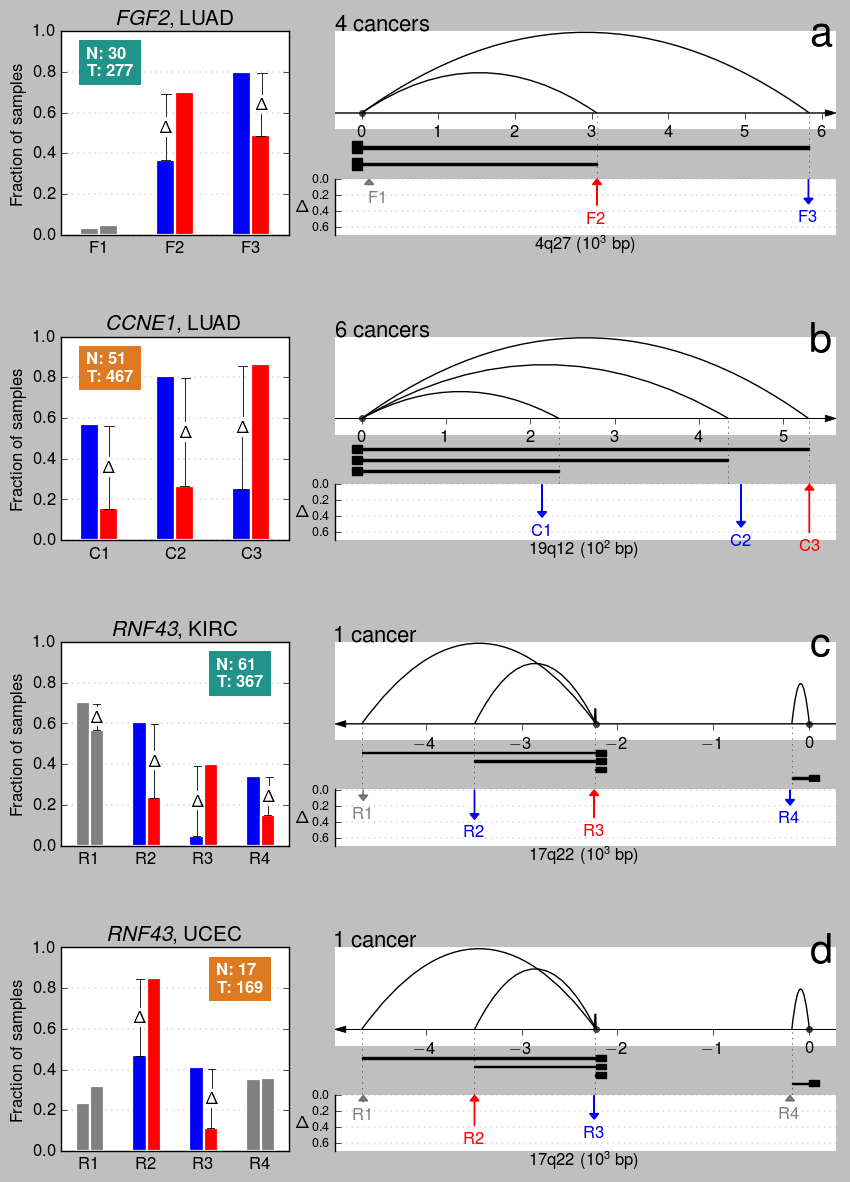

In [46]:
mlp.rc('text.latex', preamble=r'\usepackage{sfmath}')
mlp.rc('text', usetex = True)

# DEBUG = True

ymin = -1 # 1: because the max abs ratio diff is 1
ymax = 1

gd_pairs = PA.MAIN_PLOT_GD_PAIRS_SIMPLE
output = './figs/diff_apa_main_4x1_simple.jpg'
# gd_pairs = PA.MAIN_PLOT_GD_PAIRS_COMPLEX
# output = './figs/diff_apa_main_4x1_complex.jpg'
# gd_pairs = [['RNF43', 'KIRC']]


fig = plt.figure(figsize=(10, 14))
outer_grid = gridspec.GridSpec(4, 1, wspace=0, hspace=0.5)

for gki, (gene, dise) in enumerate(gd_pairs):
    print('working on {0}, {1}'.format(gene, dise), end=',')

    num_rows = 10
    num_cols = 12
    split_row1 = 5
    split_row2 = 7
    split_col = 4

#     inner_grid = gridspec.GridSpecFromSubplotSpec(
#         num_rows, num_cols, wspace=1.5, hspace=0, subplot_spec=outer_grid[gki])

    inner_grid = gridspec.GridSpecFromSubplotSpec(
        num_rows, num_cols, wspace=2, hspace=0.5, subplot_spec=outer_grid[gki])

    ax_bar = plt.Subplot(fig, inner_grid[:, :split_col])
    ax_arc = plt.Subplot(fig, inner_grid[:split_row1, split_col:])
    ax_utr = plt.Subplot(fig, inner_grid[split_row1:split_row2, split_col:])
    ax_arw = plt.Subplot(fig, inner_grid[split_row2:, split_col:])

    fig.add_subplot(ax_bar)
    fig.add_subplot(ax_arc)
    fig.add_subplot(ax_utr)
    fig.add_subplot(ax_arw)

    # left part
    gd_arw_df = ddf.query('gene_name == "{0}"'.format(gene)).query('disease == "{0}"'.format(dise))
    gd_bar_df = gd_arw_df.copy()
    
    gd_expr_df = PB.filter_expr_df(df_expr, df_clv, gene, dise)
    set_xlabel = True if gki == len(gd_pairs) - 1 else False
    PB.plot_bar_and_expr(ax_bar, gd_bar_df, gd_expr_df, set_expr_xlabel=set_xlabel, bg_color_dd=bg_color_dd)

    # right part
    gd_arc_df = arc_df.query('gene_name == "{0}"'.format(gene))
    gd_arw_df = ddf.query('gene_name == "{0}"'.format(gene)).query('disease == "{0}"'.format(dise))

    xlim = PA.calc_xlim(gd_arc_df, gd_arw_df)
    gd_arc_df = PA.process_arc_df(gd_arc_df, ymax)
    # xlim is needed for calculating arrow head width
    gd_arw_df = PA.process_arrow_df(gd_arw_df, xlim=xlim)

    ax_arc.set_zorder(1)
    ax_arw.set_zorder(9)

#     ax_arc.set_zorder(9)
#     ax_arw.set_zorder(1)

    ax_arc.xaxis.offsetText.set_visible(True)

    PA.plot_arcs_stop_codons_and_strand(ax_arc, gd_arc_df, xlim)
    PU.plot_utrs(ax_utr, gd_arc_df, xlim)
    PC.plot_clvs(ax_arw, gd_arw_df, xlim, supp=False)
    
    
    if (gene, dise) in PA.MAIN_PLOT_GD_PAIRS:
        _num = calc_recur(gene, dise)
        _txt = str(_num) + ' cancer' if _num == 1 else str(_num) + ' cancers'
        # because it needs calc_recur, so leave this part here in the notebook
        ax_arc.text(0, 1, _txt, transform=ax_arc.transAxes, fontsize=16)

    ax_arc.text(0.95, 0.85, 'abcd'[gki], transform=ax_arc.transAxes, fontsize=30)

    ticks = ax_arc.get_xticks()
    magnitude = np.floor(np.log10(ticks[-1] - ticks[0]))
    
    seqname = gd_bar_df.mkid.apply(lambda v: v.split('|')[0]).unique()[0]
    ax_arw.text(0.5, 0, '{0} ($\mathrm{{10^{1}}}$ bp)'.format(
            '{0}{1}'.format(seqname.replace('chr', ''), CB_DD[gene]),
            int(magnitude)), va='top', ha='center',transform=ax_arw.transAxes)  
#     print(ax_arc.get_xticks())
#     print([item.get_text() for item in ax_arc.get_xticklabels()])
#     break

# print('saving {0}'.format(output))
# plt.savefig(output, bbox_inches='tight', dpi=300)
# plt.close()

# Plotting the complex case with UTRs

working on CDKN2A, KIRC,['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
working on CDKN2A, HNSC,['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
working on EZH2, LUAD,['E1', 'E2', 'E3']
working on PTCH1, BRCA,['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']


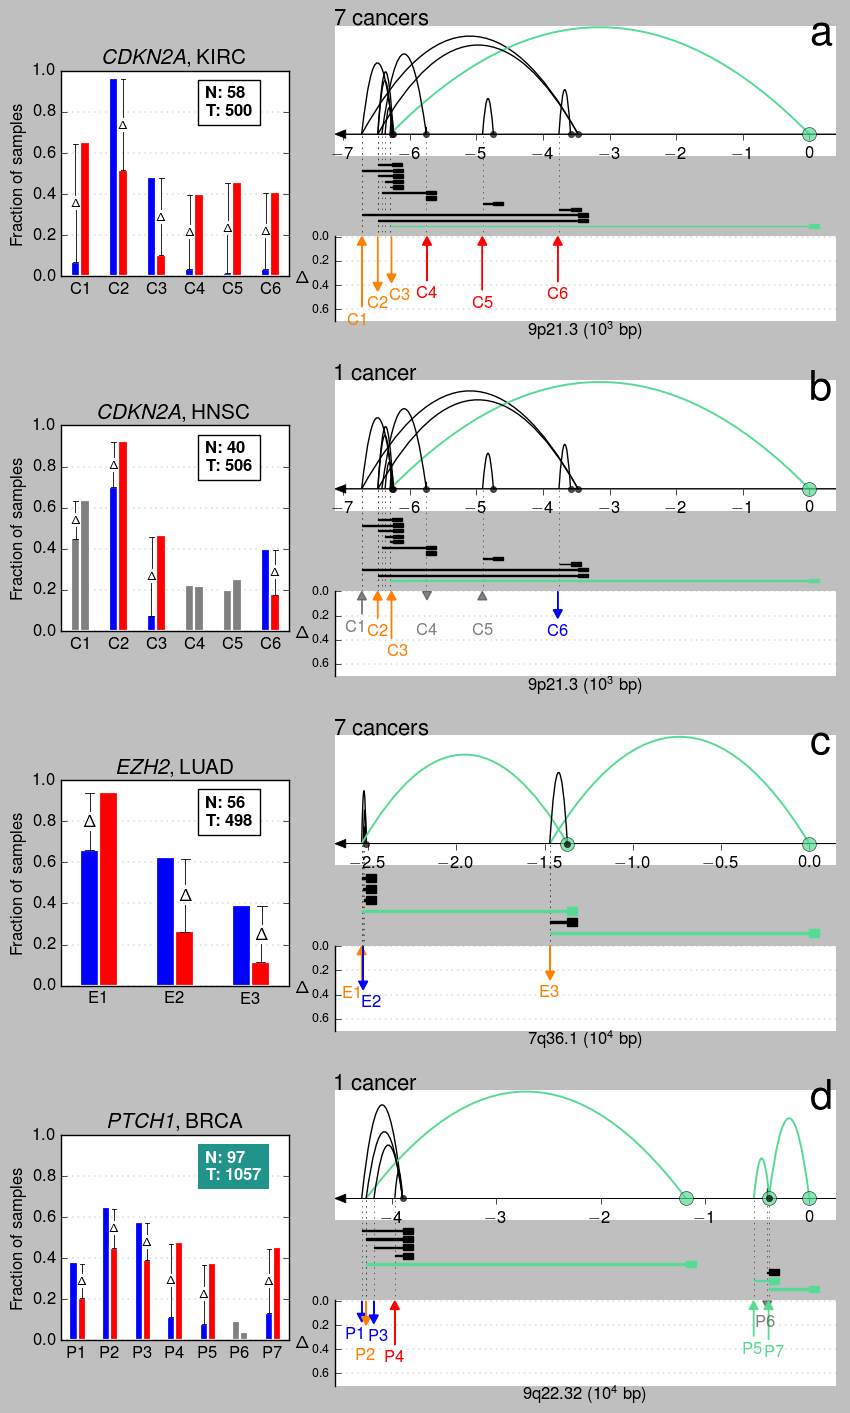

In [48]:
mlp.rc('text.latex', preamble=r'\usepackage{sfmath}')
mlp.rc('text', usetex = True)

# DEBUG = True

ymin = -1 # 1: because the max abs ratio diff is 1
ymax = 1

# gd_pairs = PA.MAIN_PLOT_GD_PAIRS_SIMPLE
# output = './figs/diff_apa_main_4x1_simple.jpg'
gd_pairs = PA.MAIN_PLOT_GD_PAIRS_COMPLEX
output = './figs/diff_apa_main_4x1_complex.jpg'
# gd_pairs = [['RNF43', 'KIRC']]


fig = plt.figure(figsize=(10, 17))
outer_grid = gridspec.GridSpec(4, 1, wspace=0, hspace=0.2)

for gki, (gene, dise) in enumerate(gd_pairs):
    print('working on {0}, {1}'.format(gene, dise), end=',')

    num_rows = 20
    num_cols = 12
    split_row1 = 9
    split_row2 = 14
    split_col = 4

#     inner_grid = gridspec.GridSpecFromSubplotSpec(
#         num_rows, num_cols, wspace=1.5, hspace=0, subplot_spec=outer_grid[gki])

    inner_grid = gridspec.GridSpecFromSubplotSpec(
        num_rows, num_cols, wspace=2, hspace=0.5, subplot_spec=outer_grid[gki])

    ax_bar = plt.Subplot(fig, inner_grid[3:-3, :split_col])
    ax_arc = plt.Subplot(fig, inner_grid[:split_row1, split_col:])
    ax_utr = plt.Subplot(fig, inner_grid[split_row1:split_row2, split_col:])
    ax_arw = plt.Subplot(fig, inner_grid[split_row2:, split_col:])

    fig.add_subplot(ax_bar)
    fig.add_subplot(ax_arc)
    fig.add_subplot(ax_utr)
    fig.add_subplot(ax_arw)

    # left part
    gd_arw_df = ddf.query('gene_name == "{0}"'.format(gene)).query('disease == "{0}"'.format(dise))
    gd_bar_df = gd_arw_df.copy()
    
    gd_expr_df = PB.filter_expr_df(df_expr, df_clv, gene, dise)
    set_xlabel = True if gki == len(gd_pairs) - 1 else False
    PB.plot_bar_and_expr(ax_bar, gd_bar_df, gd_expr_df, set_expr_xlabel=set_xlabel, bg_color_dd=bg_color_dd)

    # right part
    gd_arc_df = arc_df.query('gene_name == "{0}"'.format(gene))
    gd_arw_df = ddf.query('gene_name == "{0}"'.format(gene)).query('disease == "{0}"'.format(dise))

    xlim = PA.calc_xlim(gd_arc_df, gd_arw_df)
    gd_arc_df = PA.process_arc_df(gd_arc_df, ymax)
    # xlim is needed for calculating arrow head width
    gd_arw_df = PA.process_arrow_df(gd_arw_df, xlim=xlim)

    ax_arc.set_zorder(1)
    ax_utr.set_zorder(5)
    ax_arw.set_zorder(9)

#     ax_arc.set_zorder(9)
#     ax_arw.set_zorder(1)

    ax_arc.xaxis.offsetText.set_visible(True)

    PA.plot_arcs_stop_codons_and_strand(ax_arc, gd_arc_df, xlim)
    PU.plot_utrs(ax_utr, gd_arc_df, xlim)
    PC.plot_clvs(ax_arw, gd_arw_df, xlim, supp=False)
    
    
    if (gene, dise) in PA.MAIN_PLOT_GD_PAIRS:
        _num = calc_recur(gene, dise)
        _txt = str(_num) + ' cancer' if _num == 1 else str(_num) + ' cancers'
        # because it needs calc_recur, so leave this part here in the notebook
        ax_arc.text(0, 1, _txt, transform=ax_arc.transAxes, fontsize=16)

    ax_arc.text(0.95, 0.85, 'abcd'[gki], transform=ax_arc.transAxes, fontsize=30)

    ticks = ax_arc.get_xticks()
    magnitude = np.floor(np.log10(ticks[-1] - ticks[0]))
    
    seqname = gd_bar_df.mkid.apply(lambda v: v.split('|')[0]).unique()[0]
    ax_arw.text(0.5, 0, '{0} ($\mathrm{{10^{1}}}$ bp)'.format(
            '{0}{1}'.format(seqname.replace('chr', ''), CB_DD[gene]),
            int(magnitude)), va='top', ha='center',transform=ax_arw.transAxes)
  
#     print(ax_arc.get_xticks())
#     print([item.get_text() for item in ax_arc.get_xticklabels()])
#     break

# print('saving {0}'.format(output))
# plt.savefig(output, bbox_inches='tight', dpi=300)
# plt.close()